In [331]:
from pathlib import Path
import matplotlib
import os
from visualisation.metric_extraction_tools import plot_all_experiments_in_folder
import matplotlib.pyplot as plt
from visualisation.metric_extraction_tools import EvaluationType

os.environ["DEBUG"] = str(False)
content_root = Path(os.getcwd()).parent
checkpoints_dir = content_root / "checkpoints_translated"
# % load_ext autoreload
# % autoreload 2

In [332]:
#mn = metric_name#
mn_agg_acc = "accuracy"
#centralised
mn_c_acc = "accuracy"
mn_c_mcc = "MatthewsCorrelationCoefficient"
mn_c_macro_f1 = "macro_f1_score"
mn_c_micro_f1 = "micro_f1_score"

## Plot Tools

In [333]:
def make_list_paths(path_names, base_dir=checkpoints_dir):
    return list(map(lambda n: base_dir / n, path_names))

In [334]:
import math
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
from matplotlib.table import Cell, Table
from visualisation.metric_extraction_tools import get_all_experiments_in_folder


# Table
# Experiment Name
# Dataset Name    # Run Identier # Target Accuracy # Time to Convergenve # Smoothness
#                 # Run Identifier ....

def add_cell(self, row, col, *args, **kwargs):
    xy = (0, 0)
    cell = Cell(xy, *args, **kwargs)
    self[row, col] = cell
    return cell

Table.add_cell = add_cell

def get_target_accuracy(y):
    return max(list(map(float, y)))

def get_smoothness(y):
    y = list(map(float, y))

    variance_estimator = 0
    for y_prev, y_next in zip(y[0:-1], y[1:]):
        variance_estimator += (y_next - y_prev) ** 2
    variance_estimator /= (len(y) - 2)
    return math.sqrt(variance_estimator)


def target_accuracy_reached(target_accuracy, x, y, tolerance=0.005):
    for epoch, val in zip(x, y):
        if float(val) > target_accuracy - tolerance:
            return epoch


def format_float(val, percent=True):
    if percent:
        val *= 100.0
    return f"{val:.2f}" + " %" if percent else ""

def add_data_row(table, row, height, width, run_name, target_accuracy, epochs_to_convergence, smoothness, last_run):
    visible_edges = "B" if last_run else "open"
    table.add_cell(row, 0, 1.5*width, height, text="", visible_edges=visible_edges, loc="center")
    table.add_cell(row, 1, 1.5*width, height, text=run_name, visible_edges=visible_edges, loc="left")
    table.add_cell(row, 2, width, height, text=target_accuracy, visible_edges=visible_edges, loc="center")
    table.add_cell(row, 3, width, height, text=epochs_to_convergence, visible_edges=visible_edges, loc="center")
    table.add_cell(row, 4, width, height, text=smoothness, visible_edges=visible_edges, loc="center")
    
def add_experiment_row(table, row, height, width, experiment_name):
    cell = table.add_cell(row, 0, 1.5*width, height, fontproperties={"weight":"bold"},
                   text=experiment_name,
                   visible_edges='B',
                   loc="left")
    table.add_cell(row, 1, 1.5*width, height, text="", visible_edges='B', loc="left")
    table.add_cell(row, 2, width, height, text="", visible_edges='B', loc="left")
    table.add_cell(row, 3, width, height, text="", visible_edges='B', loc="left")
    table.add_cell(row, 4, width, height, text="", visible_edges='B', loc="left")

def add_dataset_row(table, row, height, width, dataset_name):
    table.add_cell(row, 0, 1.5*width, height,  text=dataset_name, visible_edges='TB', loc="left")
    table.add_cell(row, 1, 1.5*width, height, text="", visible_edges='TB', loc="left")
    table.add_cell(row, 2, width, height, text="", visible_edges='TB', loc="left")
    table.add_cell(row, 3, width, height, text="", visible_edges='TB', loc="left")
    table.add_cell(row, 4, width, height, text="", visible_edges='TB', loc="left")

def add_column_row(table, row, height, width):
    table.add_cell(row, 0, 1.5*width, height, text="Datset Name", visible_edges='B', loc="left")
    table.add_cell(row, 1, 1.5*width, height, text="Run Identifier", visible_edges='B', loc="left")
    table.add_cell(row, 2, width, height, text="Target Acc.", visible_edges='B', loc="center")
    table.add_cell(row, 3, width, height, text="Epochs to Conv.", visible_edges='B', loc="center")
    table.add_cell(row, 4, width, height, text="Smoothness", visible_edges='B', loc="center")


def count_rows(experiment_paths):
    rows=0
    for experiment_path in experiment_paths:
        metadata, centralised_metrics, aggregated_metrics = \
            get_all_experiments_in_folder(experiment_path, 1)
        metrics_dict = centralised_metrics
        rows += len(metrics_dict.items())

    return rows


def plot_evaluation_table(experiment_name,
                          dataset_names,
                          experiment_paths,
                          run_identifier_generator,
                          sorting_fun=None,
                          relevant_epoch_limit=None,
                          evaluation_types=None,
                          centralised_metrics_periods=None,
                          win=1):
    if relevant_epoch_limit is None:
        relevant_epoch_limit = [None for _ in dataset_names]

    if evaluation_types is None:
        evaluation_types = [EvaluationType.CENTRALISED for _ in dataset_names]

    if centralised_metrics_periods is None:
        centralised_metrics_periods = [10 for _ in dataset_names]

    cols = 6
    rows = 2 + count_rows(experiment_paths) + 1 + 0.5
    height = 0.95 / rows
    width = 0.95 / cols
    fig, ax = plt.subplots(figsize=(12, 0.5*rows))
    table = Table(ax=ax, bbox=[0,0,1,1])
    current_row = 0
    add_experiment_row(table, current_row, height, width, experiment_name)
    current_row += 1
    add_column_row(table, current_row, height, width)
    current_row += 1

    for dataset_num, (dataset_name, experiment_path) in enumerate(zip(dataset_names, experiment_paths)):
        is_last_dataset = (dataset_num+1) == len(dataset_names)
        add_dataset_row(table, current_row, height, width, dataset_name)
        current_row += 1
        multiplicator_centralised = centralised_metrics_periods[dataset_num]
        metadata, centralised_metrics, aggregated_metrics = \
            get_all_experiments_in_folder(experiment_path, multiplicator_centralised)

        evaluation_type = evaluation_types[dataset_num]
        metrics_dict = centralised_metrics if evaluation_type == EvaluationType.CENTRALISED else \
            aggregated_metrics

        if sorting_fun is not None:
            metrics = sorted(metrics_dict.items(), key=sorting_fun)
        else:
            metrics = metrics_dict.items()
        for i, (key, sub_metrics_dict) in enumerate(metrics):
            is_last_run = len(metrics_dict.items()) == (i+1)
            run_identifier = run_identifier_generator(key)
            x, y = sub_metrics_dict["accuracy"]

            def movingaverage(interval, window_size):
                interval = np.pad(interval, (0, window_size - 1), "edge")
                return np.average(sliding_window_view(interval, window_shape=window_size), axis=1)

            y = movingaverage(y, win)

            restriction_epoch = relevant_epoch_limit[dataset_num]
            if restriction_epoch is None:
                restricted_x, restricted_y = x, y
            else:
                restricted_x, restricted_y = zip(
                    *[(x_val, y_val) for x_val, y_val in zip(x, y) if x_val <= restriction_epoch])

            target_accuracy = get_target_accuracy(restricted_y)
            smoothness = get_smoothness(restricted_y)
            target_accuracy_epoch = target_accuracy_reached(target_accuracy, restricted_x,
                                                            restricted_y)
            
            add_data_row(table, current_row, height, width, run_identifier, format_float(target_accuracy),
                         str(int(target_accuracy_epoch)), f"{smoothness:.2e}", is_last_dataset and is_last_run)
            current_row += 1
    ax.axis("off")
    ax.add_table(table)
    return fig, ax



## Datasets

In [335]:
cifar10_001 = "Cifar10_Lda_0.001"
cifar10_05 = "Cifar10_Lda_0.5"
cifar10_100 = "Cifar10_Lda_100.0"
celeba = "Celeba"
femnist = "Femnist"
shakespeare = "Shakespeare"

dataset_names = [cifar10_001, cifar10_05, cifar10_100, celeba, femnist, shakespeare]
default_centralised_periods = [10, 10, 10, 10, 10, 2]

Fedavg Baselines

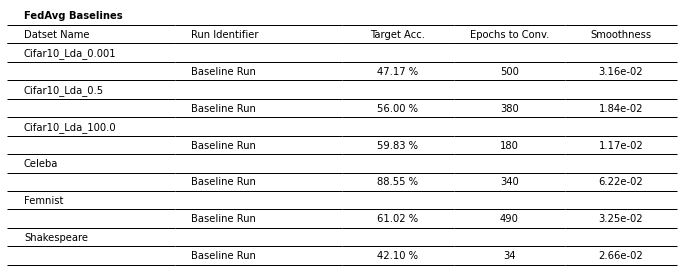

In [336]:
cifar10_001_fa = cifar10_001 + "_FedAvg"
cifar10_05_fa = cifar10_05 + "_FedAvg"
cifar10_100_fa = cifar10_100 + "_FedAvg"
cifar10_all_fa = "Cifar10_Lda_All_FedAvg"
celeba_fa = celeba + "_FedAvg"
femnist_fa = femnist + "_FedAvg"
shakespeare_fa = shakespeare + "_FedAvg"

base_names = [cifar10_001_fa, cifar10_05_fa, cifar10_100_fa, celeba_fa, femnist_fa, shakespeare_fa]
paths = make_list_paths(base_names)
run_id_gen = lambda x: f"Baseline Run"
fig, ax = plot_evaluation_table("FedAvg Baselines", dataset_names, paths, run_id_gen,
                      centralised_metrics_periods=default_centralised_periods)
fig.savefig(dpi=300,bbox_inches="tight", fname="baselines_experiment_table.png")

## Systematic Parameters

## Cohort Size

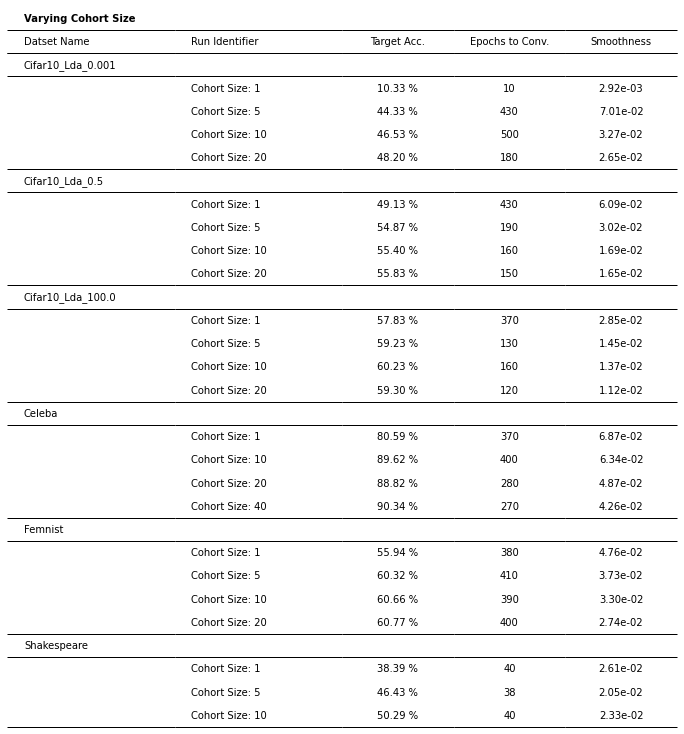

In [337]:
cifar10_001_vcs = cifar10_001 + "_Varying_Cohort_Size"
cifar10_05_vcs = cifar10_05 + "_Varying_Cohort_Size"
cifar10_100_vcs = cifar10_100 + "_Varying_Cohort_Size"
celeba_vcs = celeba + "_Varying_Cohort_Size"
femnist_vcs = femnist + "_Varying_Cohort_Size"
shakespeare_vcs = shakespeare + "_Varying_Cohort_Size_4"

base_names = [cifar10_001_vcs, cifar10_05_vcs, cifar10_100_vcs, celeba_vcs, femnist_vcs, shakespeare_vcs]
paths = make_list_paths(base_names)
run_id_gen = lambda x: "Cohort Size: " + x.split("_")[-1]
fig, ax = plot_evaluation_table("Varying Cohort Size", dataset_names, paths, run_id_gen,
                      centralised_metrics_periods=default_centralised_periods)
fig.savefig(dpi=300,bbox_inches="tight", fname="vcs_experiment_table.png")

Local Epochs

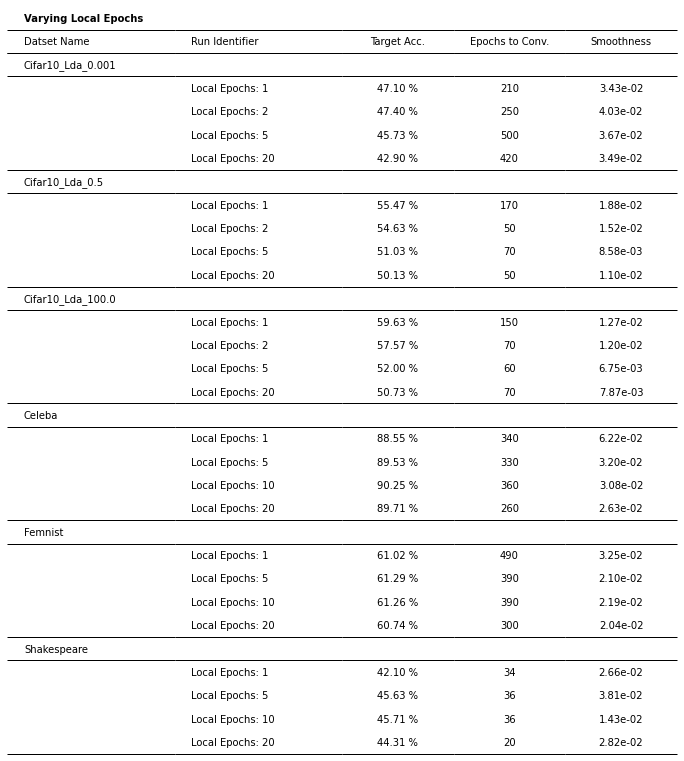

In [338]:
name = "_VLE_Final"
checkpoints_dir = checkpoints_dir.parent / "checkpoints_translated"
cifar10_001_vle = cifar10_001 + name  #"_Varying_Local_Epochs"
cifar10_05_vle = cifar10_05 + name  #"_Varying_Local_Epochs"
cifar10_100_vle = cifar10_100 + name  # "_Varying_Local_Epochs_Rerun"
celeba_vle = celeba + "_Varying_Local_Epochs"
femnist_vle = femnist + "_Varying_Local_Epochs"
shakespeare_vle = shakespeare + "_Varying_Local_Epochs"

sorting_fun = lambda p: int(p[0].split("_")[-1])
base_names = [cifar10_001_vle, cifar10_05_vle, cifar10_100_vle, celeba_vle, femnist_vle, shakespeare_vle]
paths = make_list_paths(base_names)
run_id_gen = lambda x: "Local Epochs: " + x.split("_")[-1]
fig, ax = plot_evaluation_table("Varying Local Epochs", dataset_names, paths, run_id_gen,
                      centralised_metrics_periods=default_centralised_periods,
                                sorting_fun=sorting_fun)
fig.savefig(dpi=300,bbox_inches="tight", fname="vle_experiment_table.png")

FedProx

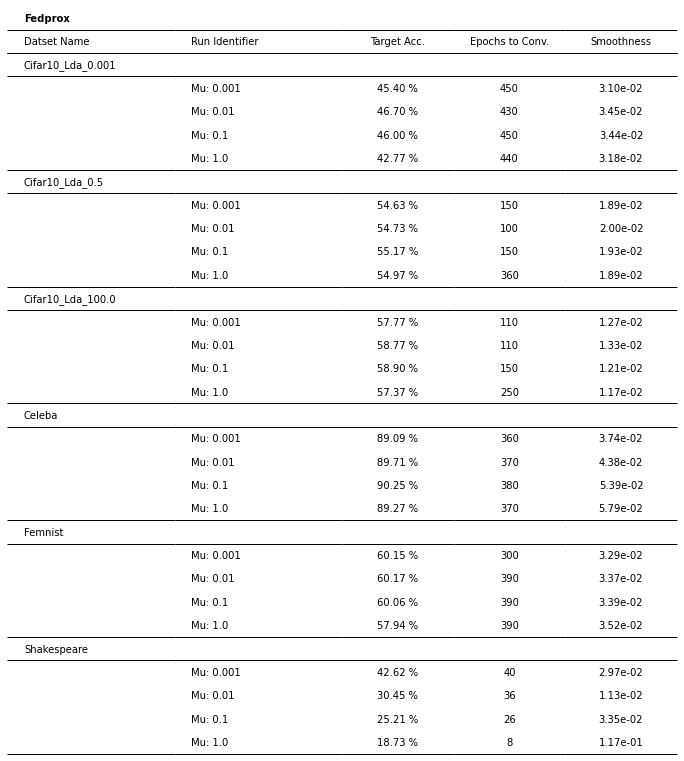

In [339]:
cifar10_001_fp = cifar10_001 + "_FedProx"
cifar10_05_fp = cifar10_05 + "_FedProx"
cifar10_100_fp = cifar10_100 + "_FedProx"
celeba_fp = celeba + "_FedProx"
femnist_fp = femnist + "_FedProx"
shakespeare_fp = shakespeare + "_FedProx"

base_names = [cifar10_001_fp, cifar10_05_fp, cifar10_100_fp, celeba_fp, femnist_fp, shakespeare_fp]
paths = make_list_paths(base_names)
run_id_gen = lambda x: "Mu: " + x.split("_")[-1]
fig, ax = plot_evaluation_table("Fedprox", dataset_names, paths, run_id_gen,
                      centralised_metrics_periods=default_centralised_periods)
fig.savefig(dpi=300,bbox_inches="tight", fname="fedprox_experiment_table.png")

Shared Global Datasets

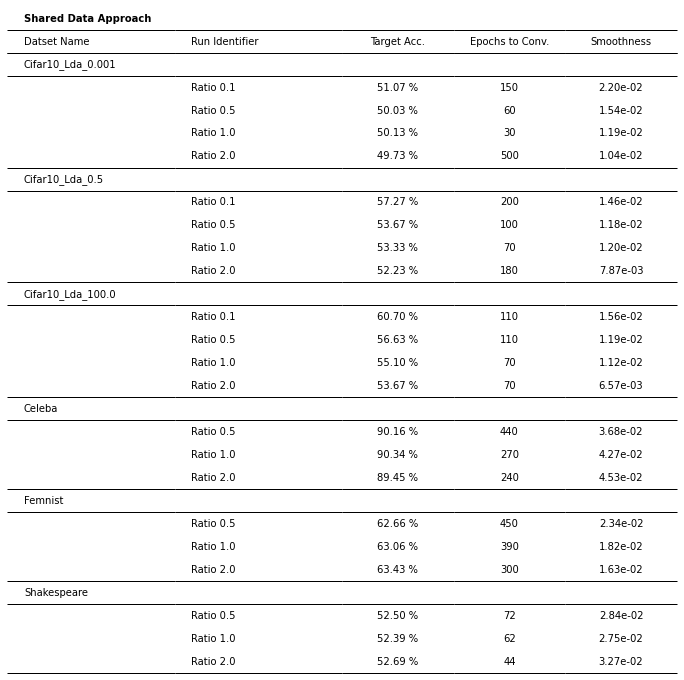

In [340]:
cifar10_001_sgd = cifar10_001 + "_Shared_Global_Dataset" + "_No_Pretraining"
cifar10_05_sgd = cifar10_05 + "_Shared_Global_Dataset" + "_No_Pretraining"
cifar10_100_sgd = cifar10_100 + "_Shared_Global_Dataset" + "_No_Pretraining"
celeba_sgd = celeba + "_Shared_Global_Dataset" + "_No_Pretraining"
femnist_sgd = femnist + "_Shared_Global_Dataset" + "_No_Pretraining"
shakespeare_sgd = shakespeare + "_Shared_Global_Dataset" + "_No_Pretraining"

base_names = [cifar10_001_sgd, cifar10_05_sgd, cifar10_100_sgd, celeba_sgd, femnist_sgd, shakespeare_sgd]
paths = make_list_paths(base_names)
run_id_gen = lambda x: "Ratio " + x.split("_")[-1]
fig, ax = plot_evaluation_table("Shared Data Approach", dataset_names, paths, run_id_gen,
                      centralised_metrics_periods=default_centralised_periods)
fig.savefig(dpi=300,bbox_inches="tight", fname="sgd_experiment_table.png")

Varying Optimisers

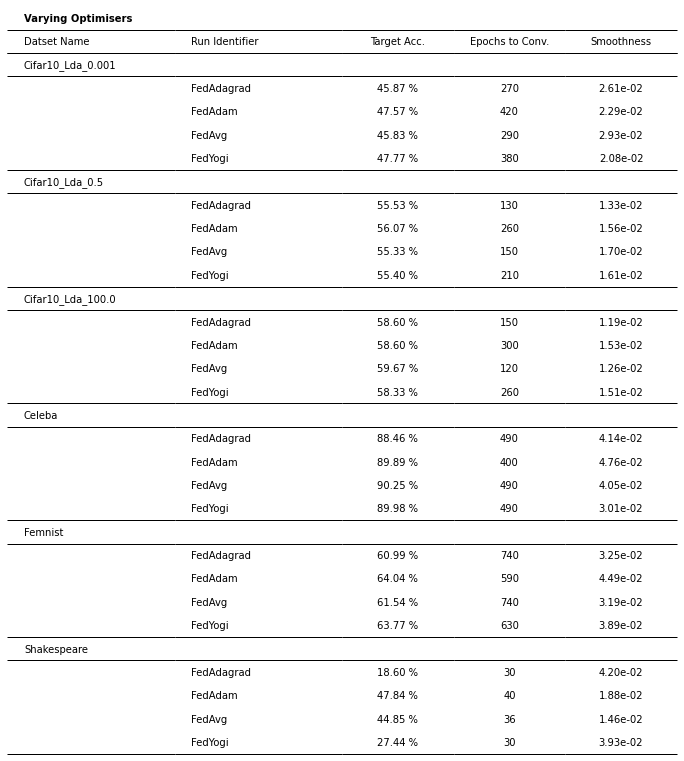

In [341]:
cifar10_001_vo = cifar10_001 + "_Varying_Optimisers"
cifar10_05_vo = cifar10_05 + "_Varying_Optimisers"
cifar10_100_vo = cifar10_100 + "_Varying_Optimisers"
celeba_vo = celeba + "_Varying_Optimisers"
femnist_vo = femnist + "_Varying_Optimisers"
shakespeare_vo = shakespeare + "_Varying_Optimisers_2"

name_dict = {
    "fedavg": "FedAvg",
    "fedadagrad": "FedAdagrad",
    "fedadam": "FedAdam",
    "fedyogi": "FedYogi"
}

base_names = [cifar10_001_vo, cifar10_05_vo, cifar10_100_vo, celeba_vo, femnist_vo, shakespeare_vo]
paths = make_list_paths(base_names)
run_id_gen = lambda n: name_dict[n.split("_")[-1]]
fig, ax = plot_evaluation_table("Varying Optimisers", dataset_names, paths, run_id_gen,
                      relevant_epoch_limit=[550, None, None, None, None, None],
                      centralised_metrics_periods=default_centralised_periods)
fig.savefig(dpi=300,bbox_inches="tight", fname="vo_experiment_table.png")

Group vs Batch Norm

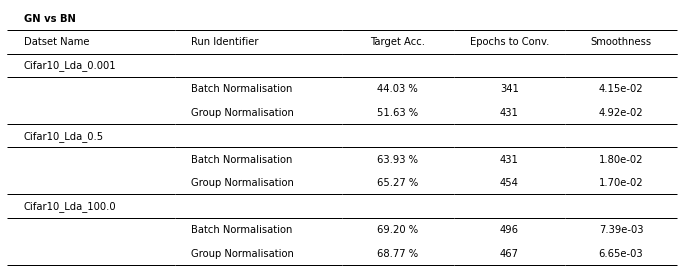

In [342]:
base_names = ["Cifar10_Lda_0.001_LeNet_BN_GN", "Cifar10_Lda_0.5_LeNet_BN_GN", "Cifar10_Lda_100.0_LeNet_BN_GN"]
paths = make_list_paths(base_names)
run_id_gen = lambda n: f"Batch Normalisation" if "bn" in n.split("_") else f"Group Normalisation"
fig, ax = plot_evaluation_table("GN vs BN", dataset_names[:3],
                                paths, run_id_gen,
                                centralised_metrics_periods=[1, 1, 1])

fig.savefig(dpi=300,bbox_inches="tight", fname="bn_gn_experiment_table.png")